### Some experiments with Cartopy to plot global maps and show earthquake locations 

This was written for the MyShake simulation project, but could be used as general reference for cartopy. Cartopy is very powerful because it is well integrated with matplotlib functionality, which is already very well developed

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import cartopy.feature as cfeature
from matplotlib.transforms import offset_copy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [23]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [24]:
client = Client("IRIS")
starttime = '1980-01-01'
endtime = '2019-04-01'
minmag = 6
quake_catalog = client.get_events(starttime=UTCDateTime(starttime),endtime=UTCDateTime(endtime),\
                            minmagnitude=minmag)

In [25]:
def get_event_of_interest(starttime,endtime,minlon,maxlon,minlat,maxlat,minmag):
    
    cat = client.get_events(starttime=UTCDateTime(starttime),endtime=UTCDateTime(endtime),\
                            minmagnitude=minmag,minlongitude=minlon,maxlongitude=maxlon,\
                            minlatitude=minlat,maxlatitude=maxlat,orderby='magnitude')
    
    return cat[0]

In [26]:
LLD = np.zeros([len(quake_catalog),3])

In [27]:
for i in range(len(quake_catalog)):
    event = quake_catalog[i]
    LLD[i,0] = event.origins[0].longitude
    LLD[i,1] = event.origins[0].latitude
    LLD[i,2] = event.magnitudes[0].mag

In [28]:
eventdetails = pd.DataFrame(LLD)
eventdetails.columns = ['LON','LAT','MAG']

In [29]:
eventdetails.head()

,LON,LAT,MAG
0,-80.8089,-1.9440,6.2
1,151.1053,-5.7003,6.2
2,159.9632,50.5022,6.2
3,126.3800,1.6617,6.1
4,-76.2231,4.5629,6.1


In [30]:
regions = {'Southern California':[-122,-115,32,35],'Northern California':[-124,-119,35,39],\
 'Korean Peninsular':[126,130,34,39],'New Zealand':[170,173,-45,-40],'Kashmir':[70,76,32,40],\
  'Haiti':[-75,-70.5,17.5,20],'Sulawesi':[117,125,-4,3],'Nepal':[80,88,26,31],\
  'Taiwan':[119.8,122.2,21.5,25.5],'Turkey':[25,35,35,43],'Chile':[-74.5,-68.5,-42,-18],\
  'Peru':[-84,-69,-20,-2],'Mexico':[-106,-95,13,23],'Central America':[-93,-76,7,19],\
  'Oklahoma':[-103.9,-94.1,33.1,37.6],'Japan':[135.6,141.2,33.3,36.7],'Italy':[10,19,40,46]}

region_dates = [['1994-01-01','1995-01-01'],['1989-01-01','1990-01-01'],['2017-01-01','2018-01-01'],\
               ['2010-01-01','2011-01-01'],['2005-01-01','2006-01-01'],['2010-01-01','2011-01-01'],['2018-01-01','2019-01-01'],\
               ['2015-01-01','2016-01-01'],['1999-01-01','2000-01-01'],['1999-01-01','2000-01-01'],['2010-01-01','2011-01-01'],\
               ['2007-01-01','2008-01-01'],['1985-01-01','1986-01-01'],['2012-01-01','2013-01-01'],['2016-01-01','2017-01-01'],\
               ['2011-01-01','2012-01-01'],['2009-01-01','2010-01-01']]

In [31]:
regions_events = {'Name':[],'Time':[],'Lon':[],'Lat':[],'Mag':[]}

for i in range(len(regions)):
    region = list(regions.keys())[i]
    coords = regions[region]
    starttime = UTCDateTime(region_dates[i][0])
    endtime = UTCDateTime(region_dates[i][1])
    #print(starttime,endtime)
    minlon = coords[0]
    maxlon = coords[1]
    minlat = coords[2]
    maxlat = coords[3]
    #print(minlon,maxlon,minlat,maxlat)
    minmagnitude=5
    quake = get_event_of_interest(starttime,endtime,\
                                  minlon,maxlon,minlat,\
                                  maxlat,minmagnitude)
    
    print('REGION: %s' %region)
    year = quake.origins[0].time.year
    month = quake.origins[0].time.month
    day = quake.origins[0].time.day
    timestr = '%s-%02d-%02d' %(year,month,day)
    
    regions_events['Name'].append(region)
    regions_events['Time'].append(timestr)
    regions_events['Lon'].append(quake.origins[0].longitude)
    regions_events['Lat'].append(quake.origins[0].latitude)
    regions_events['Mag'].append(quake.magnitudes[0].mag)
    

REGION: Southern California
REGION: Northern California
REGION: Korean Peninsular
REGION: New Zealand
REGION: Kashmir
REGION: Haiti
REGION: Sulawesi
REGION: Nepal
REGION: Taiwan
REGION: Turkey
REGION: Chile
REGION: Peru
REGION: Mexico
REGION: Central America
REGION: Oklahoma
REGION: Japan
REGION: Italy


In [32]:
regions_events = pd.DataFrame(regions_events)

In [33]:
regions_events.head()

,Name,Time,Lon,Lat,Mag
0,Southern California,1994-01-17,-118.5826,34.1360,6.7
1,Northern California,1989-10-18,-121.7895,37.0608,6.9
2,Korean Peninsular,2017-11-15,129.2695,36.0645,5.4
3,New Zealand,2010-09-03,171.9023,-43.3608,7.0
4,Kashmir,2005-10-08,73.6400,34.5239,7.6


In [34]:
def convert_to_box(box):
    
    x = [box[0],box[1],box[1],box[0],box[0]]
    y = [box[3],box[3],box[2],box[2],box[3]]
    c = (box[1],box[3])
    
    return x,y,c

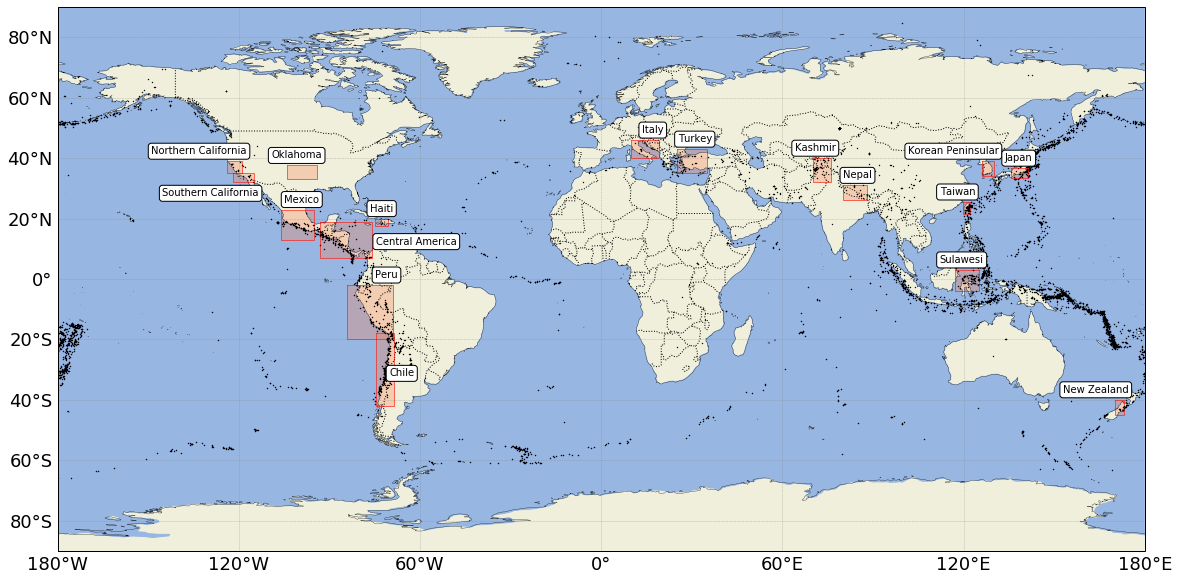

In [38]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.coastlines(resolution='50m',linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')

geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right= False 

for region in regions.keys():
    
    if region == 'Southern California':
        text_transform = offset_copy(geodetic_transform, units='dots', x=5,y=-20)
    elif region == 'Northern California':
        text_transform = offset_copy(geodetic_transform, units='dots', x=5,y=10)
    elif region == 'Central America':
        text_transform = offset_copy(geodetic_transform, units='dots', x=85,y=-20)
    elif region == 'Chile':
        text_transform = offset_copy(geodetic_transform, units='dots', x=20,y=-40)
    else:
        text_transform = offset_copy(geodetic_transform, units='dots', x=5,y=10)
        
    coords = regions[region]
    x,y,c = convert_to_box(coords)
    
    ax.plot(eventdetails['LON'],eventdetails['LAT'],'k.',transform=ccrs.PlateCarree(),markersize=0.1)
    ax.plot(x,y, transform=ccrs.PlateCarree(), color='red',linewidth=0.5)
    ax.fill(x,y, transform=ccrs.PlateCarree(), color='coral', alpha=0.3)
    
    #ax.plot(regions_events['Lon'],\
    #        regions_events['Lat'], 'ro',transform=ccrs.PlateCarree(),markersize=10)
    
    ax.text(c[0], c[1], region,
       verticalalignment='center', horizontalalignment='right',
       transform=text_transform,
       bbox=dict(facecolor='white', alpha=1, boxstyle='round'))

    
plt.savefig('Global_MyShake_regions.pdf',dpi=200)

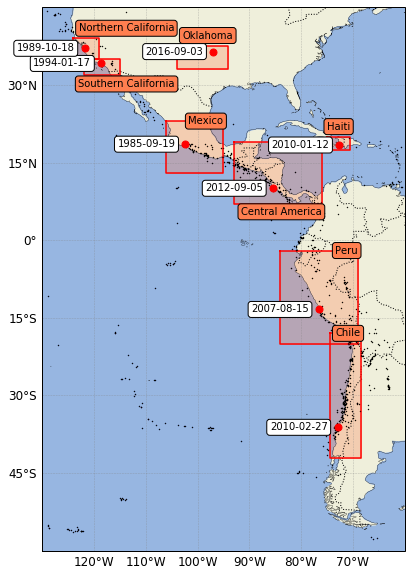

In [39]:
minlat_extent = -60
maxlat_extent = 45
minlon_extent = -130
maxlon_extent = -60

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([minlon_extent, maxlon_extent, \
               minlat_extent, maxlat_extent], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.coastlines(resolution='50m',linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right= False 


geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
text_transform_event = offset_copy(geodetic_transform, units='dots', x=-10,y=0)

#loop though the names of the major events and plot them
for region in regions_events['Name']:
    
    #print(region)
    coords = regions[region]
    x,y,c = convert_to_box(coords)
    
    ax.plot(eventdetails['LON'],eventdetails['LAT'],'k.',transform=ccrs.PlateCarree(),markersize=0.1)
    ax.plot(x,y, transform=ccrs.PlateCarree(), color='red')
    ax.fill(x,y, transform=ccrs.PlateCarree(), color='coral', alpha=0.3)
    
    event_details = regions_events[regions_events['Name']==region]
    event_lon = event_details['Lon'].values[0]
    event_lat = event_details['Lat'].values[0]
    event_id = event_details['Time'].values[0]
    
    if (minlon_extent <= event_lon <= maxlon_extent) and \
       (minlat_extent <= event_lat <= maxlat_extent):
        
        if region == 'Northern California':
            
            text_transform = offset_copy(geodetic_transform, units='dots', x=75,y=10)
        
        elif region == 'Southern California':
            
            text_transform = offset_copy(geodetic_transform, units='dots', x=55,y=-25)
            
        elif region == 'Oklahoma':
            
            text_transform = offset_copy(geodetic_transform, units='dots', x=5,y=10)
            
        elif region == 'Central America':
            
            text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=-70)
            
        elif region == 'Haiti':
            
            text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)
            
        else:
            text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=0)
            
            
        ax.text(c[0], c[1], region,
                verticalalignment='center', horizontalalignment='right',
                transform=text_transform,
                bbox=dict(facecolor='coral', alpha=1, boxstyle='round'))
    
        #ax.text(c[0], c[1], region,
        #   verticalalignment='center', horizontalalignment='right',
        #   bbox=dict(facecolor='white', alpha=1, boxstyle='round'))
        
        ax.text(event_lon, event_lat, event_id,
           verticalalignment='center', horizontalalignment='right',transform=text_transform_event,
           bbox=dict(facecolor='white', alpha=1, boxstyle='round'))
    
ax.plot(regions_events['Lon'],\
            regions_events['Lat'], 'ro',transform=ccrs.PlateCarree(),markersize=7)

plt.savefig("Americas_regions.pdf",dpi=200)
